In [1]:
import os
import sys
import pdb
import json
import copy
import glob
import h5py
import numpy as np
import pandas as pd
import scipy.io.wavfile
import time
import importlib
import tensorflow as tf

from tensorflow.python.training import py_checkpoint_reader

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import util_tfrecords
import util_signal
import util_cochlea
import util_network
import util_optimize
import util_evaluate
import util_figures
import util_stimuli
import util_misc


def azim_elev_to_label(azim, elev):
    """
    """
    label = (elev / 10) * 72 + (azim / 5)
    return np.array(label).astype(int)


def label_to_azim_elev(label):
    """
    """
    elev = np.array((label // 72) * 10)
    azim = np.array((label % 72) * 5)
    return np.array(azim).astype(float), np.array(elev).astype(float)


In [21]:
"""
Load example stimuli as well as subbands and softmax model outputs generated with Andrew's code
"""
sr = 48e3
example_stim = np.load('example_stim.npz', allow_pickle=True)

list_y = []
for itr_y, raw_y in enumerate(example_stim['orig_stim']):
    y = np.frombuffer(raw_y, dtype=float).reshape([-1, 2]).astype(np.float32)
    list_y.append(y)
list_y = np.array(list_y)
list_y = list_y[:, :int(sr), :]
list_subbands = np.stack(example_stim['coch'])
list_softmax = np.array(example_stim['softmax'], dtype=np.float32)

print('list_y', list_y.shape, list_y.dtype)
print('list_subbands', list_subbands.shape, list_subbands.dtype)
print('list_softmax', list_softmax.shape, list_softmax.dtype)

for itr in range(list_y.shape[0]):
    ipd.display(ipd.Audio(rate=sr, data=list_y[itr].T))


list_y (8, 48000, 2) float32
list_subbands (8, 39, 48000, 2) float32
list_softmax (8, 504) float32


In [11]:
"""
Convert subbands generated with Andrew's code to final cochlear representation
(rectified, downsampled, compressed) using my own tensorflow2 code.
"""
list_coch = util_signal.tfnnresample(
    tensor_input=tf.nn.relu(list_subbands),
    sr_input=48e3,
    sr_output=8e3,
    kwargs_nnresample_poly_filter={
        "down": 6,
        "up": 1,
        "window_length": 4097,
        "legacy": True,
    },
    verbose=True)
list_coch = tf.nn.relu(list_coch)
list_coch = tf.math.pow(list_coch, 0.3)
list_coch = list_coch.numpy()
list_coch.shape


[tfnnresample] interpreting `tensor_input.shape` as [batch, freq, time, channels]
[tfnnresample] using up=1 rather than up=1 for nnresample_poly_filter
[tfnnresample] using down=6 rather than down=6 for nnresample_poly_filter
[tfnnresample] using cutoff frequency near 4000.0 Hz for anti-aliasing lowpass filter


(8, 39, 8000, 2)

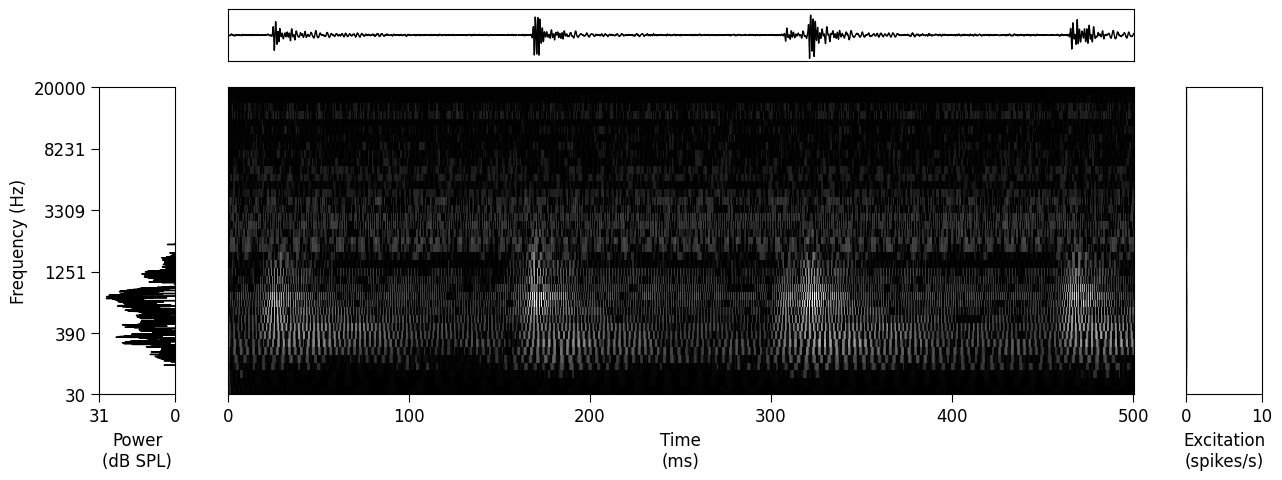

In [13]:
"""
Visualize resulting cochlear representation (i.e., the network input)
"""
figsize = (15, 5)
nrows = 2
ncols = 3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 12, 1],
    'height_ratios': [1, 6],
}
IDX = 1 # Stimulus index
CHANNEL = 0 # Channel index (left or right)
waveform = list_y[IDX, :, CHANNEL]
sr_waveform = 48e3
nervegram = list_coch[IDX, :, :, CHANNEL].astype('float32')
sr_nervegram = 8e3
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(
    ax_arr,
    ax_idx_waveform=1,
    ax_idx_spectrum=3,
    ax_idx_nervegram=4,
    ax_idx_excitation=5,
    waveform=waveform,
    nervegram=nervegram,
    sr_waveform=sr_waveform,
    sr_nervegram=sr_nervegram,
    cfs=util_stimuli.erbspace(30, 20e3, 39),
    tmin=0.0,
    tmax=0.5,
    treset=False)
plt.show()


In [16]:
"""
Build tensorflow2 objects for the `network_model and the `cochlea_model`.

The `cochlea_model` has no learnable parameters and does not require a checkpoint to be loaded.
The `network_model` parameters are loaded from a checkpoint file
    (see end of this notebook for proof that my tf2-model-compatible checkpoint contains
    exactly the same weights as Andrews tf1-model-compatible checkpoints) 
"""
dir_model = 'saved_models/tf2_model/archFrancl01'
fn_arch = os.path.join(dir_model, 'arch.json')
fn_config = os.path.join(dir_model, 'config.json')
fn_ckpt = os.path.join(dir_model, 'ckpt_BEST')

with open(fn_arch, 'r') as f:
    list_layer_dict = json.load(f)
with open(fn_config, 'r') as f:
    CONFIG = json.load(f)
    CONFIG['kwargs_cochlea']['kwargs_nnresample_poly_filter_output']['legacy'] = True


def network_model_io_function(x):
    y = x
    y, _ = util_network.build_network(y, list_layer_dict, n_classes_dict=CONFIG['n_classes_dict'])
    return y


def cochlea_model_io_function(x):
    y = x
    if CONFIG.get('kwargs_cochlea', {}):
        msg = "expected input with shape [batch, time, channel=2]"
        assert (len(y.shape) == 3) and (y.shape[-1] == 2), msg
        # Cochlear model for ear index 0
        y0, _ = util_cochlea.cochlea(y[..., 0], **copy.deepcopy(CONFIG['kwargs_cochlea']))
        # Cochlear model for ear index 1
        y1, _ = util_cochlea.cochlea(y[..., 1], **copy.deepcopy(CONFIG['kwargs_cochlea']))
        # Binaural cochlear model representation with shape [batch, freq, time, channel=2]
        y = tf.concat([y0[..., tf.newaxis], y1[..., tf.newaxis]], axis=-1)
        msg = "expected cochlear model output with shape [batch, freq, time, channel=2]"
        assert (len(y.shape) == 4) and (y.shape[-1] == 2), msg
    return y


tf.keras.backend.clear_session()
inputs_sound = tf.keras.Input(shape=(48000, 2), batch_size=None, dtype=tf.float32)
inputs_coch = tf.keras.Input(shape=(39, 8000, 2), batch_size=None, dtype=tf.float32)
cochlea_model = tf.keras.Model(inputs=inputs_sound, outputs=cochlea_model_io_function(inputs_sound))
network_model = tf.keras.Model(inputs=inputs_coch, outputs=network_model_io_function(inputs_coch))

tf.get_logger().setLevel('ERROR')
network_model.load_weights(fn_ckpt)
print('Loaded: {}'.format(fn_ckpt))
tf.get_logger().setLevel('INFO')


[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[cochlea] resampled subbands from 48000 Hz to 8000 Hz with filter: {'down': 6, 'legacy': True, 'up': 1, 'window_length': 4097}
[cochlea] half-wave rectified resampled subbands
[cochlea] applied 0.3 power compression to subbands
[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[cochlea] resampled subbands from 48000 Hz to 8000 Hz with filter: {'down': 6, 'legacy': True, 'up': 1, 'window_length': 4097}
[cochlea] half-wave rectified resampled subbands
[cochlea] applied 0.3 power compression to subbands
Loaded: saved_models/tf2_model/archFrancl01/ckpt_BEST


In [17]:
"""
Run the models:

`softmax_francl`: model outputs from evaluating just the network model on `list_coch`
    (pre-prepared cochlear model outputs that exactly match Andrew's cochlear representations)
`softmax_msaddler`: model outputs from evaluating directly on sound (`list_y`)
"""
softmax_francl = scipy.special.softmax(
    network_model(list_coch)['label_loc_int'].numpy(),
    axis=-1)
softmax_msaddler = scipy.special.softmax(
    network_model(cochlea_model(list_y))['label_loc_int'].numpy(),
    axis=-1)


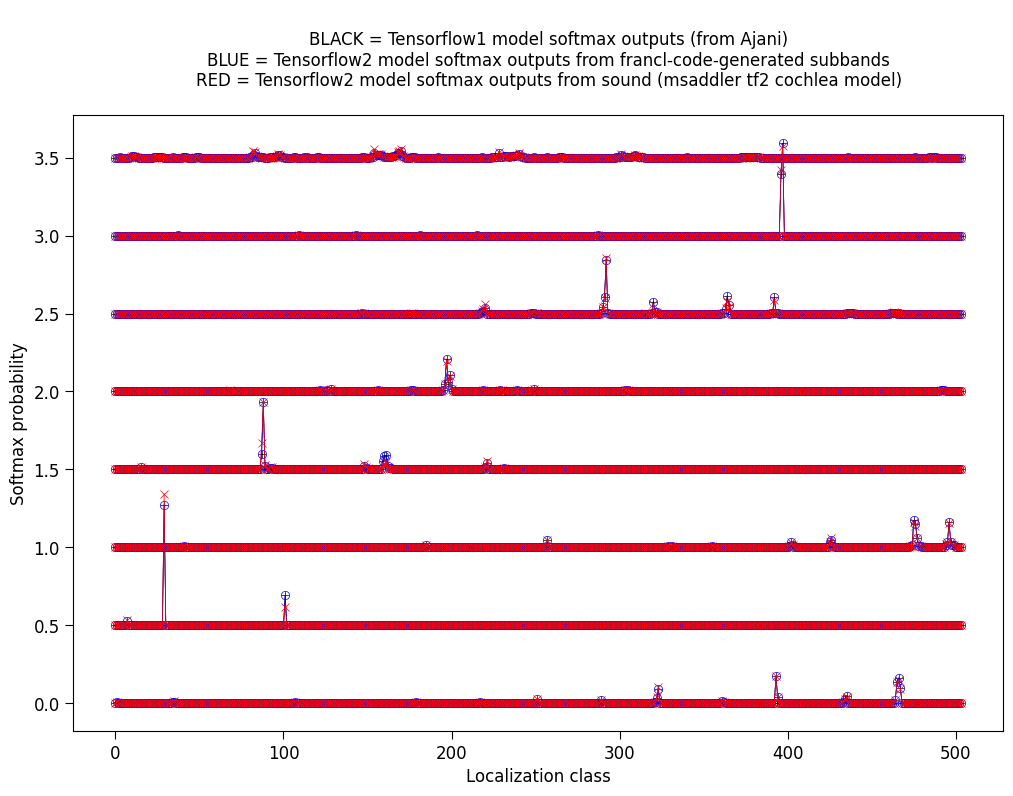

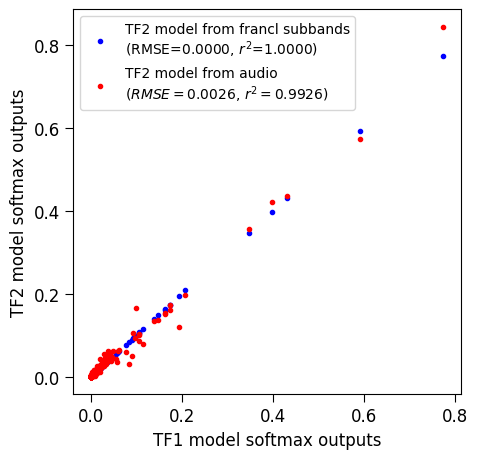

In [37]:
"""
Compare model outputs to those generated directly with Andrew's code
"""
fig, ax = plt.subplots(figsize=(12, 8))
for itr0 in range(list_softmax.shape[0]):
    kwargs_plot = {
        'mew': 0.5,
        'mfc': 'none',
        'lw': 0.5,
        'ls': '-',
        'ms': 6,
    }
    offset = itr0 / 2
    ax.plot(list_softmax[itr0] + offset, color='k', marker='+', **kwargs_plot)
    ax.plot(softmax_francl[itr0] + offset, color='b', marker='o', **kwargs_plot)
    ax.plot(softmax_msaddler[itr0] + offset, color='r', marker='x', **kwargs_plot)
ax = util_figures.format_axes(
    ax,
    str_title="""
    BLACK = Tensorflow1 model softmax outputs (from Ajani)
    BLUE = Tensorflow2 model softmax outputs from francl-code-generated subbands
    RED = Tensorflow2 model softmax outputs from sound (msaddler tf2 cochlea model)
    """,
    str_xlabel='Localization class',
    str_ylabel='Softmax probability')
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
x_tf1_from_ajani = list_softmax.reshape([-1])
y_tf2_from_subbands = softmax_francl.reshape([-1])
y_tf2_from_sound = softmax_msaddler.reshape([-1])
rmse_tf2_from_subbands = np.sqrt(np.mean(np.square(x_tf1_from_ajani - y_tf2_from_subbands)))
rmse_tf2_from_sound = np.sqrt(np.mean(np.square(x_tf1_from_ajani - y_tf2_from_sound)))
r_tf2_from_subbands, _ = scipy.stats.pearsonr(x_tf1_from_ajani, y_tf2_from_subbands)
r_tf2_from_sound, _ = scipy.stats.pearsonr(x_tf1_from_ajani, y_tf2_from_sound)
label_tf2_from_subbands = "TF2 model from francl subbands\n(RMSE={:.4f}, $r^2$={:.4f})".format(
    rmse_tf2_from_subbands, r_tf2_from_subbands)
label_tf2_from_sound = "TF2 model from audio\n($RMSE=${:.4f}, $r^2=${:.4f})".format(
    rmse_tf2_from_sound, r_tf2_from_sound)
ax.plot(x_tf1_from_ajani, y_tf2_from_subbands, 'b.', label=label_tf2_from_subbands)
ax.plot(x_tf1_from_ajani, y_tf2_from_sound, 'r.', label=label_tf2_from_sound)
ax.legend()
ax = util_figures.format_axes(
    ax,
    str_xlabel='TF1 model softmax outputs',
    str_ylabel='TF2 model softmax outputs')
plt.show()


In [19]:
"""
Test full model on a batch of naturalistic sounds and print out performance
"""
fn = '/om2/user/msaddler/data_localize/FLDv01/valid/stim_000000-004763.hdf5'
with h5py.File(fn, 'r') as f:
    sr_hdf5 = f['sr'][0]
    sr = 48e3
    
    IDX = slice(100, 116)
    y = f['signal'][IDX]    
    y = scipy.signal.resample_poly(y, up=sr, down=sr_hdf5, axis=1)
#     for itr0 in range(y.shape[0]):
#         ipd.display(ipd.Audio(rate=sr, data=y[itr0].T))
#     print(y.shape, y.dtype, sr)
    
    azim = f['foreground_azimuth'][IDX]
    elev = f['foreground_elevation'][IDX]
    label = azim_elev_to_label(azim, elev)
    

y_out = network_model(cochlea_model(y[:, 22800:22800 + 48000, :]))['label_loc_int'].numpy()
y_pred = scipy.special.softmax(y_out, axis=-1)
label_pred = np.argmax(y_out, axis=-1)

azim_pred, elev_pred = label_to_azim_elev(label_pred)

print('True labels: {}'.format(label))
print('Pred labels: {}'.format(label_pred))
print('True azim: {}'.format(azim.astype(int)))
print('Pred azim: {}'.format(azim_pred.astype(int)))
print('True elev: {}'.format(elev.astype(int)))
print('Pred elev: {}'.format(elev_pred.astype(int)))


True labels: [296 170 170 224 443  51 306  84 152 260 332 478 498 347 440 429]
Pred labels: [296 171 170 244 443  51 306  96 225 209 332 478 499 347 441 428]
True azim: [ 40 130 130  40  55 255  90  60  40 220 220 230 330 295  40 345]
Pred azim: [ 40 135 130 140  55 255  90 120  45 325 220 230 335 295  45 340]
True elev: [40 20 20 30 60  0 40 10 20 30 40 60 60 40 60 50]
Pred elev: [40 20 20 30 60  0 40 10 30 20 40 60 60 40 60 50]


In [4]:
def load_legacy_checkpoint(model, fn_ckpt, verbose=True):
    """
    Loads weights from Francl & McDermott (2022) tensorflow1
    checkpoints into tensorflow2 Keras model objects.
    """
    model_variables = {v.name: v for v in model.variables}
    reader = py_checkpoint_reader.NewCheckpointReader(fn_ckpt)
    map_ckpt_var_to_shape = reader.get_variable_to_shape_map()
    relevant_variables = {}
    
    for k_ckpt in sorted(map_ckpt_var_to_shape.keys()):
        if ('Adam' not in k_ckpt) and (k_ckpt not in ['beta1_power', 'beta2_power']):
            k_rel = k_ckpt
            if 'norm' in k_rel:
                k_rel = k_rel.replace('batch_normalization', 'batch_norm')
                k_rel = k_rel.replace('norm/', 'norm_0/')
                if 'archFrancl01' in fn_ckpt:
                    k_rel = k_rel.replace('norm_8', 'norm_fc_intermediate')
                elif 'archFrancl02' in fn_ckpt:
                    k_rel = k_rel.replace('norm_9', 'norm_fc_intermediate')
                elif 'archFrancl03' in fn_ckpt:
                    k_rel = k_rel.replace('norm_10', 'norm_fc_intermediate')
                elif 'archFrancl04' in fn_ckpt:
                    k_rel = k_rel.replace('norm_8', 'norm_fc_intermediate')
                elif 'archFrancl05' in fn_ckpt:
                    k_rel = k_rel.replace('norm_9', 'norm_fc_intermediate')
                elif 'archFrancl06' in fn_ckpt:
                    k_rel = k_rel.replace('norm_7', 'norm_fc_intermediate')
                elif 'archFrancl07' in fn_ckpt:
                    k_rel = k_rel.replace('norm_7', 'norm_fc_intermediate')
                elif 'archFrancl08' in fn_ckpt:
                    k_rel = k_rel.replace('norm_9', 'norm_fc_intermediate')
                elif 'archFrancl09' in fn_ckpt:
                    k_rel = k_rel.replace('norm_9', 'norm_fc_intermediate')
                elif 'archFrancl10' in fn_ckpt:
                    k_rel = k_rel.replace('norm_4', 'norm_fc_intermediate')
                else:
                    raise ValueError('NO IDEA HOW TO DEAL WITH THIS ARCHITECTURE')
            if 'wb' in k_rel:
                tmp = k_rel.split('_')
                k_rel = 'conv_{}/bias'.format(tmp[1])
            if 'wc' in k_rel:
                tmp = k_rel.split('_')
                k_rel = 'conv_{}/kernel'.format(tmp[1])
            if 'fc' in k_rel:
                k_rel = k_rel.replace('conv_fc', 'fc_intermediate')
            if 'out' in k_rel:
                k_rel = k_rel.replace('conv_out', 'fc_top')
            k_rel = k_rel + ':0'
            
            consumed = False
            for v in model.variables:
                if k_rel == v.name:
                    if not map_ckpt_var_to_shape[k_ckpt] == v.shape:
                        print('--> {}:{}    |    {}:{}'.format(v.name, v.shape, k_ckpt, map_ckpt_var_to_shape[k_ckpt]))
                    relevant_variables[k_rel] = reader.get_tensor(k_ckpt)
                    consumed = True
            if (not consumed) and (verbose):
                print('IGNORING VARIABLE IN CKPT: {}'.format(k_rel), k_ckpt, map_ckpt_var_to_shape[k_ckpt])
    
    for v in model.variables:
        if v.name in relevant_variables:
            assert v.shape == relevant_variables[v.name].shape
            assert v.dtype == relevant_variables[v.name].dtype
            v.assign(relevant_variables[v.name])
        else:
            raise ValueError('VARIABLE MISSING FROM CKPT: {} {}'.format(v.name, v.shape))
    return


In [5]:
"""
I organize my models as individual directories. Each model has it's own directory containing:
- `config.json`: specifies the cochlear model, all training parameters, and output shape of the network
- `arch.json`: specifies the architecture of the neural network
- Model checkpoint(s)
- Training log(s)
- Model evaluation outputs

Below is a config dictionary (typically stored as `config.json` in the individual model directories)
I would use to train a variant of the Francl & McDermott (2022) model directly on sound waveforms.

The important parts are `kwargs_cochlea` and `n_classes_dict`:
- `kwargs_cochlea`: specifies the parameters of the cochlear model built in tensorflow
- `n_classes_dict`: specifies the output layer's shape and name
"""
CONFIG = {
    "kwargs_cochlea": {
        "config_filterbank": {
            "max_hi": 20000.0,
            "min_lo": 30.0,
            "mode": "half_cosine_filterbank",
            "num_cf": 39
        },
        "config_subband_processing": {
            "power_compression": 0.3,
            "rectify": True
        },
        "kwargs_nnresample_poly_filter_input": {},
        "kwargs_nnresample_poly_filter_output": {
            "down": 6,
            "legacy": True,
            "up": 1,
            "window_length": 4097
        },
        "sr_cochlea": 48000,
        "sr_input": 48000,
        "sr_output": 8000
    },
    "kwargs_dataset_from_tfrecords": {
        "buffer_size_prefetch": 5,
        "buffer_size_shuffle": 100,
        "bytes_description": "config_bytes_description.pckl",
        "feature_description": "config_feature_description.pckl",
        "features_to_exclude": [
            "nervegram_meanrates"
        ]
    },
    "kwargs_optimize": {
        "basename_ckpt_best": "ckpt_BEST",
        "basename_ckpt_epoch": None,
        "basename_log": "log_optimize.csv",
        "batch_size": 16,
        "early_stopping_baseline": None,
        "early_stopping_min_delta": 0,
        "early_stopping_patience": None,
        "epochs": 50,
        "key_inputs": "signal",
        "key_outputs": "label_loc_int",
        "kwargs_loss": {
            "from_logits": True,
            "name": "SparseCategoricalCrossentropy",
            "weight": 1.0
        },
        "kwargs_optimizer": {
            "amsgrad": False,
            "beta_1": 0.9,
            "beta_2": 0.999,
            "epsilon": 1e-07,
            "learning_rate": 0.001,
            "name": "Adam"
        },
        "monitor_metric": "val_accuracy",
        "monitor_mode": "max",
        "steps_per_epoch": 10000,
        "validation_steps": 500
    },
    "n_classes_dict": {
        "label_loc_int": 504
    }
}


In [6]:
tf.get_logger().setLevel('ERROR') # Suppress warnings about variable identifiers not matching

list_dir_model = glob.glob('saved_models/tf2_model/archFrancl??')
input_shape = (48000, 2)

for dir_model in list_dir_model:
    fn_arch = os.path.join(dir_model, 'arch.json')
    fn_config = os.path.join(dir_model, 'config.json')
    fn_ckpt_tf2 = os.path.join(dir_model, 'ckpt_BEST')
    fn_ckpt_tf1 = os.path.join(dir_model.replace('tf2_model', 'tf1_model'), 'model.ckpt-100000')
    
    with open(fn_arch, 'r') as f:
        list_layer_dict = json.load(f)
    with open(fn_config, 'w') as f:
        json.dump(CONFIG, f, sort_keys=True, indent=4)
    
    def model_io_function(x):
        """
        This functions describes how the model should convert inputs to outputs.
        It will be used to build the tensorflow model object.
        """
        y = x
        if CONFIG.get('kwargs_cochlea', {}):
            msg = "expected input with shape [batch, time, channel=2]"
            assert (len(y.shape) == 3) and (y.shape[-1] == 2), msg
            # Cochlear model for ear index 0
            y0, _ = util_cochlea.cochlea(y[..., 0], **copy.deepcopy(CONFIG['kwargs_cochlea']))
            # Cochlear model for ear index 1
            y1, _ = util_cochlea.cochlea(y[..., 1], **copy.deepcopy(CONFIG['kwargs_cochlea']))
            # Binaural cochlear model representation with shape [batch, freq, time, channel=2]
            y = tf.concat([y0[..., tf.newaxis], y1[..., tf.newaxis]], axis=-1)
            msg = "expected cochlear model output with shape [batch, freq, time, channel=2]"
            assert (len(y.shape) == 4) and (y.shape[-1] == 2), msg
        y, _ = util_network.build_network(y, list_layer_dict, n_classes_dict=CONFIG['n_classes_dict'])
        return y
    
    tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape=input_shape, batch_size=None, dtype=tf.float32)
    model = tf.keras.Model(inputs=inputs, outputs=model_io_function(inputs))
    
    weights_init = {v.name: v.numpy() for v in model.weights}
    print('Loading weights: {}'.format(fn_ckpt_tf1))
    load_legacy_checkpoint(model, fn_ckpt_tf1) # Load weights from tensorflow1 checkpoint
    weights_tf1 = {v.name: v.numpy() for v in model.weights}
    print('Loading weights: {}'.format(fn_ckpt_tf2))
    model.load_weights(fn_ckpt_tf2) # Load weights from tensorflow2 checkpoint
    weights_tf2 = {v.name: v.numpy() for v in model.weights}
    
    for k in sorted(weights_init.keys()):
        tf1_equals_init = np.array_equal(weights_init[k], weights_tf1[k])
        tf2_equals_init = np.array_equal(weights_init[k], weights_tf2[k])
        tf2_equals_tf1 = np.array_equal(weights_tf2[k], weights_tf1[k])
        # Throw errors if a variable does not match between tf1 and tf2 model (or is missing from checkpoint)
        msg = "Unexpected checkpoint behavior for variable {} with shape {}".format(k, weights_init[k].shape)
        assert not tf1_equals_init, msg
        assert not tf2_equals_init, msg
        assert tf2_equals_tf1, msg


[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[cochlea] resampled subbands from 48000 Hz to 8000 Hz with filter: {'down': 6, 'legacy': True, 'up': 1, 'window_length': 4097}
[cochlea] half-wave rectified resampled subbands
[cochlea] applied 0.3 power compression to subbands
[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[cochlea] resampled subbands from 48000 Hz to 8000 Hz with filter: {'down': 6, 'legacy': True, 'up': 1, 'window_length': 4097}
[cochlea] half-wave rectified resampled subbands
[cochlea] applied 0.3 power compression to subbands
Loading weights: saved_models/tf1_model/archFrancl01/model.ckpt-100000
Loading weights: saved_models/tf2_model/archFrancl01/ckpt_BEST
[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[cochlea] resampled subbands from 48000 Hz to 8000 Hz with filter: {'down': 6, 'legacy': 

In [6]:
"""
CONFIG for example training model. Note there are some modifications from the
original Francl & McDermott (2022) model (number of filters, sampling rates,
length of anti-aliasing lowpass filter, optimization hyperparameters)
"""

CONFIG = {
    "kwargs_cochlea": {
        "config_filterbank": {
            "max_hi": 20000.0,
            "min_lo": 20.0,
            "mode": "half_cosine_filterbank",
            "num_cf": 50
        },
        "config_subband_processing": {
            "power_compression": 0.3,
            "rectify": True
        },
        "kwargs_custom_slice": {
            "args": [
                1000,
                11000
            ],
            "axis": 2
        },
        "kwargs_nnresample_poly_filter_input": {},
        "kwargs_nnresample_poly_filter_output": {
            "down": 5,
            "legacy": False,
            "up": 1,
            "window_length": 2001
        },
        "sr_cochlea": 40000,
        "sr_input": 40000,
        "sr_output": 10000
    },
    "kwargs_dataset_from_tfrecords": {
        "buffer_size_prefetch": 5,
        "buffer_size_shuffle": 100,
        "bytes_description": "config_bytes_description.pckl",
        "feature_description": "config_feature_description.pckl",
        "features_to_exclude": [
            "nervegram_meanrates"
        ]
    },
    "kwargs_optimize": {
        "basename_ckpt_best": "ckpt_BEST",
        "basename_ckpt_epoch": None,
        "basename_log": "log_optimize.csv",
        "batch_size": 32,
        "early_stopping_baseline": None,
        "early_stopping_min_delta": 0,
        "early_stopping_patience": None,
        "epochs": 40,
        "key_inputs": "signal",
        "key_outputs": "label_loc_int",
        "kwargs_loss": {
            "from_logits": True,
            "name": "SparseCategoricalCrossentropy",
            "weight": 1.0
        },
        "kwargs_optimizer": {
            "amsgrad": False,
            "beta_1": 0.9,
            "beta_2": 0.999,
            "epsilon": 1e-07,
            "learning_rate": 0.0001,
            "name": "Adam"
        },
        "monitor_metric": "val_accuracy",
        "monitor_mode": "max",
        "steps_per_epoch": 10000,
        "validation_steps": 500
    },
    "n_classes_dict": {
        "label_loc_int": 504
    }
}

regex_model = '/om2/user/msaddler/francl_mcdermott_tf2/saved_models/msaddler_tf2_model_example/archFrancl??'
list_dir_model = glob.glob(regex_model)
for dir_model in list_dir_model:
    fn_config = os.path.join(dir_model, 'config.json')
    with open(fn_config, 'w') as f:
        json.dump(CONFIG, f, indent=4, sort_keys=True)
    print(fn_config)


/om2/user/msaddler/francl_mcdermott_tf2/saved_models/msaddler_tf2_model_example/archFrancl01/config.json
/om2/user/msaddler/francl_mcdermott_tf2/saved_models/msaddler_tf2_model_example/archFrancl02/config.json
/om2/user/msaddler/francl_mcdermott_tf2/saved_models/msaddler_tf2_model_example/archFrancl03/config.json
/om2/user/msaddler/francl_mcdermott_tf2/saved_models/msaddler_tf2_model_example/archFrancl04/config.json
/om2/user/msaddler/francl_mcdermott_tf2/saved_models/msaddler_tf2_model_example/archFrancl05/config.json
/om2/user/msaddler/francl_mcdermott_tf2/saved_models/msaddler_tf2_model_example/archFrancl06/config.json
/om2/user/msaddler/francl_mcdermott_tf2/saved_models/msaddler_tf2_model_example/archFrancl07/config.json
/om2/user/msaddler/francl_mcdermott_tf2/saved_models/msaddler_tf2_model_example/archFrancl08/config.json
/om2/user/msaddler/francl_mcdermott_tf2/saved_models/msaddler_tf2_model_example/archFrancl09/config.json
/om2/user/msaddler/francl_mcdermott_tf2/saved_models/ms